# BGP-Sentry Experiment Analysis: `caida_200`

**Results directory:** `results/caida_200/20260213_194255`

This notebook provides a comprehensive analysis of a single BGP-Sentry blockchain simulation run, covering:

1. **Experiment Overview** - Dataset, configuration, system info
2. **Detection Performance** - Precision/recall/F1, confusion matrix, per-type breakdown
3. **Blockchain Performance** - Block production, integrity, per-node replicas
4. **Consensus Analysis** - Commit rates, timeout analysis, vote distribution
5. **BGPCoin Token Economy** - Treasury, distribution, per-node balances
6. **Non-RPKI Trust Ratings** - Score distribution, longitudinal behavior
7. **P2P Network Analysis** - Message throughput, delivery rates
8. **Cryptographic Signing** - Key generation, signature verification
9. **Deduplication Effectiveness** - RPKI vs non-RPKI dedup rates
10. **Real-Time Feasibility** - Can this run in real-time? Throughput analysis
11. **Attack Verdict Analysis** - Consensus voting on detected attacks

In [1]:
import json
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from pathlib import Path
from collections import Counter, defaultdict
from datetime import datetime

# Style
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.1)
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100

RESULTS_DIR = Path("/home/anik/code/BGP-Sentry/results/caida_200/20260213_194255")

def load_json(filename):
    with open(RESULTS_DIR / filename) as f:
        return json.load(f)

# Load all result files
summary        = load_json("summary.json")
run_config     = load_json("run_config.json")
performance    = load_json("performance_metrics.json")
detection_results = load_json("detection_results.json")
trust_scores   = load_json("trust_scores.json")
blockchain_stats = load_json("blockchain_stats.json")
bgpcoin_economy  = load_json("bgpcoin_economy.json")
nonrpki_ratings  = load_json("nonrpki_ratings.json")
consensus_log    = load_json("consensus_log.json")
attack_verdicts  = load_json("attack_verdicts.json")
dedup_stats      = load_json("dedup_stats.json")
bus_stats        = load_json("message_bus_stats.json")
crypto_summary   = load_json("crypto_summary.json")

print(f"Loaded caida_200 results from {RESULTS_DIR}")
print(f"Duration: {summary['elapsed_seconds']:.1f}s")

Loaded caida_200 results from /home/anik/code/BGP-Sentry/results/caida_200/20260213_194255
Duration: 100.6s


## 1. Experiment Overview

In [2]:
ds = summary["dataset"]
ns = summary["node_summary"]
sysinfo = run_config.get("system_info", {})

overview = pd.DataFrame([
    ("Dataset", ds.get("dataset_name")),
    ("Total ASes", ds.get("total_ases")),
    ("RPKI Validators", ds.get("rpki_count")),
    ("Non-RPKI Observers", ds.get("non_rpki_count")),
    ("Total Observations", f"{ds.get('total_observations', 0):,}"),
    ("Attack Observations", f"{ds.get('attack_observations', 0):,} ({100*ds.get('attack_observations',0)/max(ds.get('total_observations',1),1):.1f}%)"),
    ("Duration", f"{summary['elapsed_seconds']:.1f}s"),
    ("Nodes Completed", f"{ns.get('nodes_done')}/{ns.get('total_nodes')}"),
    ("CPU", sysinfo.get("cpu_model", "N/A")),
    ("Cores", sysinfo.get("cpu_count", "N/A")),
    ("RAM", f"{sysinfo.get('memory_total_gb', 'N/A')} GB"),
], columns=["Metric", "Value"])

display(overview.style.hide(axis="index").set_properties(**{'text-align': 'left'}))

Metric,Value
Dataset,caida_200
Total ASes,200
RPKI Validators,101
Non-RPKI Observers,99
Total Observations,"15,038"
Attack Observations,476 (3.2%)
Duration,100.6s
Nodes Completed,200/200
CPU,13th Gen Intel(R) Core(TM) i7-13700
Cores,24


## 2. Detection Performance

In [3]:
# Performance metrics table
perf_df = pd.DataFrame([
    ("Ground Truth Attacks", performance["ground_truth_attacks"]),
    ("Total Detections (unique)", performance["total_detections"]),
    ("True Positives", performance["true_positives"]),
    ("False Positives", performance["false_positives"]),
    ("False Negatives", performance["false_negatives"]),
    ("Precision", f"{performance['precision']:.4f}"),
    ("Recall", f"{performance['recall']:.4f}"),
    ("F1 Score", f"{performance['f1_score']:.4f}"),
], columns=["Metric", "Value"])

display(perf_df.style.hide(axis="index").set_properties(**{'text-align': 'left'}))

Metric,Value
Ground Truth Attacks,4
Total Detections (unique),48
True Positives,4
False Positives,44
False Negatives,0
Precision,0.0833
Recall,1.0000
F1 Score,0.1538


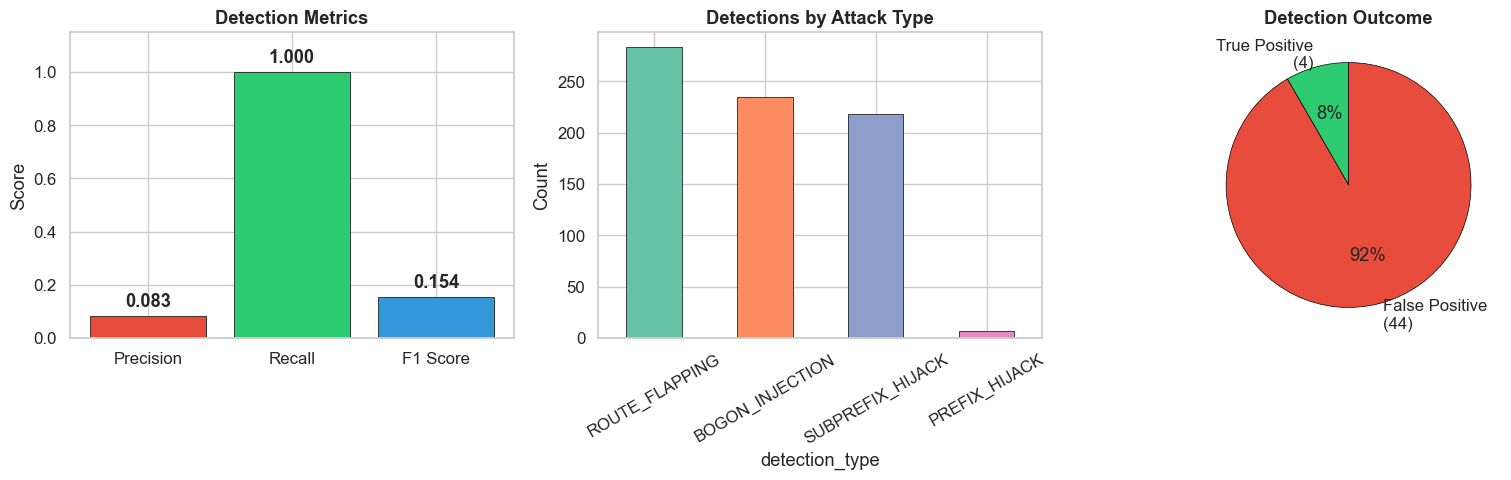

In [4]:
# Confusion matrix visualization
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 1. Precision / Recall / F1 bar chart
metrics = ["Precision", "Recall", "F1 Score"]
values = [performance["precision"], performance["recall"], performance["f1_score"]]
colors = ["#e74c3c", "#2ecc71", "#3498db"]
bars = axes[0].bar(metrics, values, color=colors, edgecolor="black", linewidth=0.5)
for bar, val in zip(bars, values):
    axes[0].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.02,
                f'{val:.3f}', ha='center', va='bottom', fontweight='bold')
axes[0].set_ylim(0, 1.15)
axes[0].set_title("Detection Metrics", fontweight="bold")
axes[0].set_ylabel("Score")

# 2. Detection type breakdown
det_df = pd.DataFrame(detection_results)
detected_only = det_df[det_df["detected"] == True]
if not detected_only.empty:
    type_counts = detected_only["detection_type"].value_counts()
    type_counts.plot.bar(ax=axes[1], color=sns.color_palette("Set2", len(type_counts)),
                         edgecolor="black", linewidth=0.5)
    axes[1].set_title("Detections by Attack Type", fontweight="bold")
    axes[1].set_ylabel("Count")
    axes[1].tick_params(axis='x', rotation=30)
else:
    axes[1].text(0.5, 0.5, "No detections", ha="center", va="center")

# 3. TP / FP / FN pie chart
tp, fp, fn = performance["true_positives"], performance["false_positives"], performance["false_negatives"]
sizes = [tp, fp, fn]
labels_pie = [f"True Positive\n({tp})", f"False Positive\n({fp})", f"False Negative\n({fn})"]
colors_pie = ["#2ecc71", "#e74c3c", "#f39c12"]
# Remove zero slices
nonzero = [(s, l, c) for s, l, c in zip(sizes, labels_pie, colors_pie) if s > 0]
if nonzero:
    s, l, c = zip(*nonzero)
    axes[2].pie(s, labels=l, colors=c, autopct='%1.0f%%', startangle=90,
                wedgeprops={'edgecolor': 'black', 'linewidth': 0.5})
axes[2].set_title("Detection Outcome", fontweight="bold")

plt.tight_layout()
plt.savefig(RESULTS_DIR / "fig_detection_performance.png", dpi=150, bbox_inches="tight")
plt.show()

### 2.1 Per-Node Detection Analysis

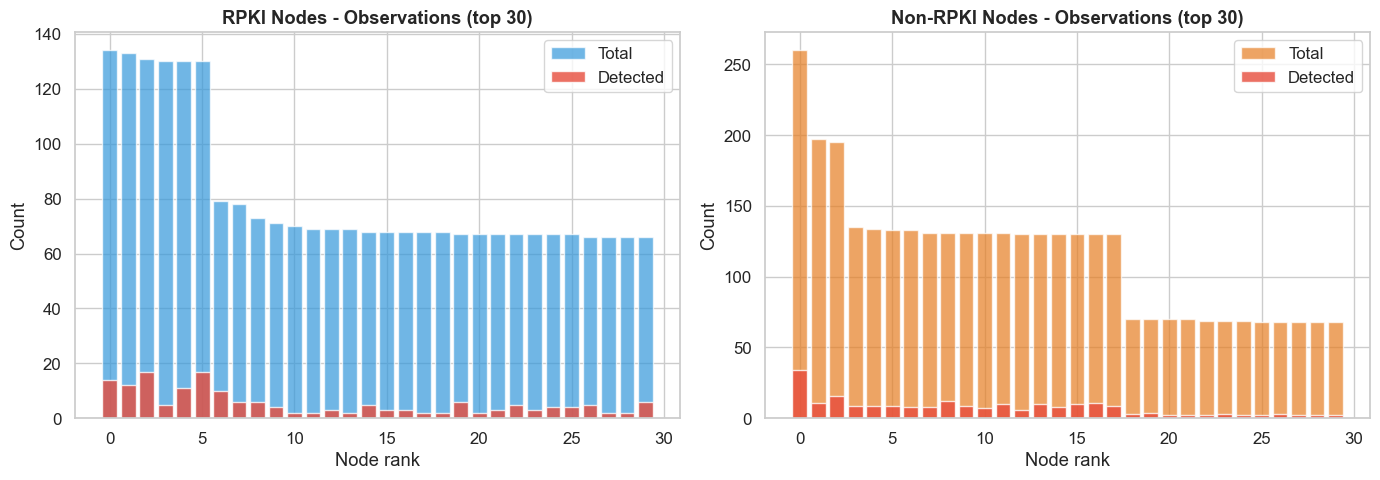

RPKI nodes: 101, Non-RPKI nodes: 99
Avg observations per RPKI node: 70.1
Avg observations per Non-RPKI node: 80.4


In [5]:
det_df = pd.DataFrame(detection_results)

# Per-node observation counts
node_stats = det_df.groupby("asn").agg(
    total=("asn", "count"),
    attacks_detected=("detected", "sum"),
    is_attack_gt=("is_attack", "sum"),
).reset_index()

# Separate RPKI and non-RPKI
rpki_nodes = set()
nonrpki_nodes = set()
for asn_str, info in trust_scores.items():
    asn = int(asn_str)
    if info.get("is_rpki"):
        rpki_nodes.add(asn)
    else:
        nonrpki_nodes.add(asn)

node_stats["node_type"] = node_stats["asn"].apply(
    lambda x: "RPKI" if x in rpki_nodes else "Non-RPKI"
)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Observations per node by type
for i, ntype in enumerate(["RPKI", "Non-RPKI"]):
    subset = node_stats[node_stats["node_type"] == ntype].sort_values("total", ascending=False)
    if len(subset) > 30:
        subset = subset.head(30)  # Top 30
    axes[i].bar(range(len(subset)), subset["total"], color="#3498db" if ntype == "RPKI" else "#e67e22",
                alpha=0.7, label="Total")
    axes[i].bar(range(len(subset)), subset["attacks_detected"], color="#e74c3c", alpha=0.8, label="Detected")
    axes[i].set_title(f"{ntype} Nodes - Observations (top {len(subset)})", fontweight="bold")
    axes[i].set_xlabel("Node rank")
    axes[i].set_ylabel("Count")
    axes[i].legend()

plt.tight_layout()
plt.savefig(RESULTS_DIR / "fig_per_node_detections.png", dpi=150, bbox_inches="tight")
plt.show()

print(f"RPKI nodes: {len(rpki_nodes)}, Non-RPKI nodes: {len(nonrpki_nodes)}")
print(f"Avg observations per RPKI node: {node_stats[node_stats['node_type']=='RPKI']['total'].mean():.1f}")
print(f"Avg observations per Non-RPKI node: {node_stats[node_stats['node_type']=='Non-RPKI']['total'].mean():.1f}")

### 2.2 Observation Processing Pipeline

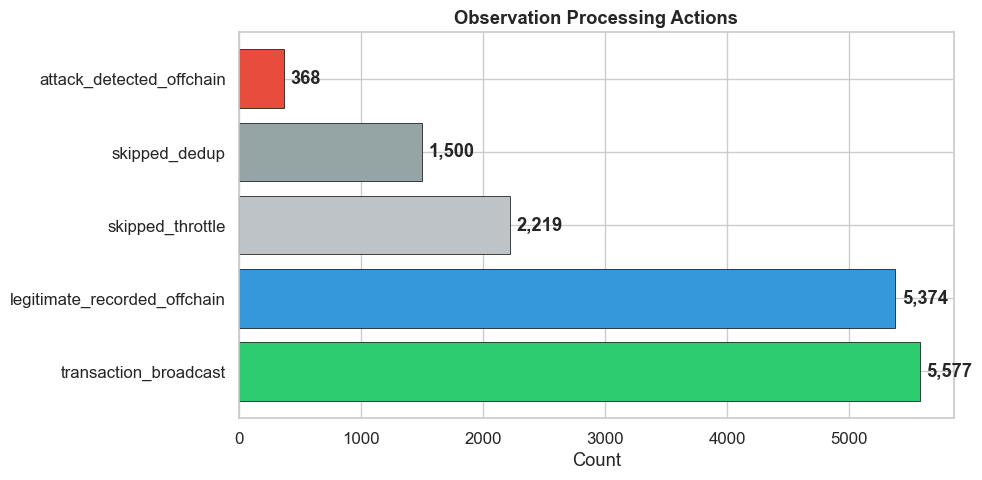

In [6]:
det_df = pd.DataFrame(detection_results)
action_counts = det_df["action"].value_counts()

fig, ax = plt.subplots(figsize=(10, 5))
colors_map = {
    "transaction_broadcast": "#2ecc71",
    "skipped_dedup": "#95a5a6",
    "legitimate_recorded_offchain": "#3498db",
    "skipped_throttle": "#bdc3c7",
    "attack_detected_offchain": "#e74c3c",
    "no_p2p_pool": "#f39c12",
}
colors = [colors_map.get(a, "#7f8c8d") for a in action_counts.index]

bars = ax.barh(range(len(action_counts)), action_counts.values, color=colors, edgecolor="black", linewidth=0.5)
ax.set_yticks(range(len(action_counts)))
ax.set_yticklabels(action_counts.index)
for bar, val in zip(bars, action_counts.values):
    ax.text(bar.get_width() + max(action_counts.values)*0.01, bar.get_y() + bar.get_height()/2.,
            f'{val:,}', ha='left', va='center', fontweight='bold')
ax.set_title("Observation Processing Actions", fontweight="bold")
ax.set_xlabel("Count")
plt.tight_layout()
plt.savefig(RESULTS_DIR / "fig_action_distribution.png", dpi=150, bbox_inches="tight")
plt.show()

## 3. Blockchain Performance

In [7]:
bc_info = blockchain_stats["blockchain_info"]
integrity = blockchain_stats["integrity"]
replicas = blockchain_stats.get("node_replicas", {})

bc_df = pd.DataFrame([
    ("Total Blocks", f"{bc_info.get('total_blocks', 0):,}"),
    ("Total Transactions", f"{bc_info.get('total_transactions', 0):,}"),
    ("Latest Block #", bc_info.get("latest_block", {}).get("block_number", "N/A")),
    ("Integrity Valid", "Yes" if integrity.get("valid") else "No"),
    ("Integrity Errors", len(integrity.get("errors", []))),
    ("Node Replicas", replicas.get("total_nodes", 0)),
    ("All Replicas Valid", "Yes" if replicas.get("all_valid") else "No"),
    ("Valid Replicas", f"{replicas.get('valid_count', 0)}/{replicas.get('total_nodes', 0)}"),
], columns=["Metric", "Value"])

display(bc_df.style.hide(axis="index").set_properties(**{'text-align': 'left'}))

# Blocks per second
elapsed = summary["elapsed_seconds"]
blocks = bc_info.get("total_blocks", 0)
print(f"\nBlock production rate: {blocks/elapsed:.1f} blocks/sec")
print(f"Transaction throughput: {bc_info.get('total_transactions', 0)/elapsed:.1f} tx/sec")

Metric,Value
Total Blocks,"1,774"
Total Transactions,"1,773"
Latest Block #,1773
Integrity Valid,Yes
Integrity Errors,0
Node Replicas,101
All Replicas Valid,Yes
Valid Replicas,101/101



Block production rate: 17.6 blocks/sec
Transaction throughput: 17.6 tx/sec


## 4. Consensus Analysis

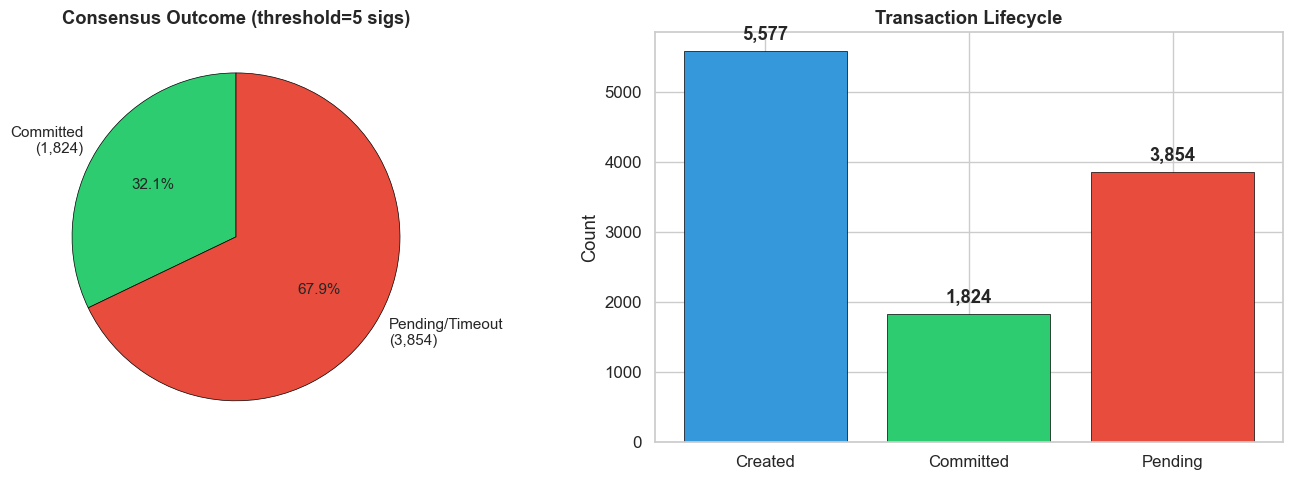

Commit rate: 32.7%
Transactions per second (created): 55.4
Transactions per second (committed): 18.1


In [8]:
created = consensus_log.get("total_transactions_created", 0)
committed = consensus_log.get("total_committed", 0)
pending = consensus_log.get("total_pending", 0)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Commit vs Pending pie
if created > 0:
    sizes = [committed, pending]
    labels = [f"Committed\n({committed:,})", f"Pending/Timeout\n({pending:,})"]
    colors = ["#2ecc71", "#e74c3c"]
    axes[0].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90,
                wedgeprops={'edgecolor': 'black', 'linewidth': 0.5}, textprops={'fontsize': 11})
    axes[0].set_title(f"Consensus Outcome (threshold={run_config.get('consensus_threshold', 'N/A')} sigs)", fontweight="bold")

# 2. Transactions created vs committed bar
categories = ["Created", "Committed", "Pending"]
values = [created, committed, pending]
bars = axes[1].bar(categories, values, color=["#3498db", "#2ecc71", "#e74c3c"],
                   edgecolor="black", linewidth=0.5)
for bar, val in zip(bars, values):
    axes[1].text(bar.get_x() + bar.get_width()/2., bar.get_height() + max(values)*0.02,
                f'{val:,}', ha='center', va='bottom', fontweight='bold')
axes[1].set_title("Transaction Lifecycle", fontweight="bold")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.savefig(RESULTS_DIR / "fig_consensus.png", dpi=150, bbox_inches="tight")
plt.show()

commit_rate = committed / max(created, 1)
print(f"Commit rate: {commit_rate:.1%}")
print(f"Transactions per second (created): {created / summary['elapsed_seconds']:.1f}")
print(f"Transactions per second (committed): {committed / summary['elapsed_seconds']:.1f}")

## 5. BGPCoin Token Economy

Metric,Value
Total Supply,"10,000,000"
Treasury Balance,"9,976,548"
Total Distributed,"23,452"
Total Burned,0
Circulating Supply,"22,012"
Participating Nodes,101


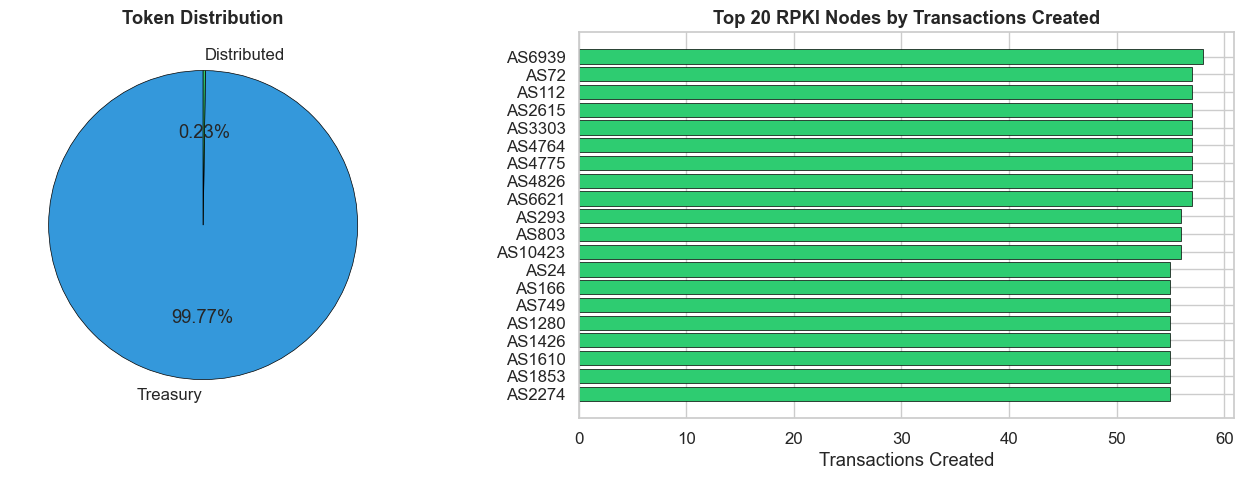

In [9]:
eco_df = pd.DataFrame([
    ("Total Supply", f"{bgpcoin_economy.get('total_supply', 0):,}"),
    ("Treasury Balance", f"{bgpcoin_economy.get('treasury_balance', 0):,.0f}"),
    ("Total Distributed", f"{bgpcoin_economy.get('total_distributed', 0):,.0f}"),
    ("Total Burned", f"{bgpcoin_economy.get('total_burned', 0):,.0f}"),
    ("Circulating Supply", f"{bgpcoin_economy.get('circulating_supply', 0):,.0f}"),
    ("Participating Nodes", bgpcoin_economy.get('nodes_count', 0)),
], columns=["Metric", "Value"])

display(eco_df.style.hide(axis="index").set_properties(**{'text-align': 'left'}))

# Token distribution visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Treasury vs Distributed
supply = bgpcoin_economy.get("total_supply", 10_000_000)
treasury = bgpcoin_economy.get("treasury_balance", 0)
distributed = bgpcoin_economy.get("total_distributed", 0)
burned = bgpcoin_economy.get("total_burned", 0)

sizes = [treasury, distributed - burned, burned] if burned > 0 else [treasury, distributed]
labels = (["Treasury", "Circulating", "Burned"] if burned > 0
          else ["Treasury", "Distributed"])
colors = (["#3498db", "#2ecc71", "#e74c3c"] if burned > 0
          else ["#3498db", "#2ecc71"])
axes[0].pie(sizes, labels=labels, colors=colors, autopct='%1.2f%%', startangle=90,
            wedgeprops={'edgecolor': 'black', 'linewidth': 0.5})
axes[0].set_title("Token Distribution", fontweight="bold")

# 2. Per-node BGPCOIN balances (from trust_scores stats)
node_balances = {}
for asn_str, info in trust_scores.items():
    if info.get("is_rpki"):
        # Approximate balance from stats
        stats = info.get("stats", {})
        created = stats.get("transactions_created", 0)
        node_balances[int(asn_str)] = created

if node_balances:
    sorted_nodes = sorted(node_balances.items(), key=lambda x: x[1], reverse=True)
    top_n = sorted_nodes[:20]
    asns = [f"AS{a}" for a, _ in top_n]
    vals = [v for _, v in top_n]
    axes[1].barh(range(len(asns)), vals, color="#2ecc71", edgecolor="black", linewidth=0.5)
    axes[1].set_yticks(range(len(asns)))
    axes[1].set_yticklabels(asns)
    axes[1].invert_yaxis()
    axes[1].set_title("Top 20 RPKI Nodes by Transactions Created", fontweight="bold")
    axes[1].set_xlabel("Transactions Created")

plt.tight_layout()
plt.savefig(RESULTS_DIR / "fig_bgpcoin_economy.png", dpi=150, bbox_inches="tight")
plt.show()

## 6. Non-RPKI Trust Ratings

Metric,Value
Total Rated ASes,57
Average Score,40.35
Min Score,0
Max Score,50
Total Attacks Detected,48


/tmp/ipykernel_1482211/3447303099.py:68: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[2].legend()


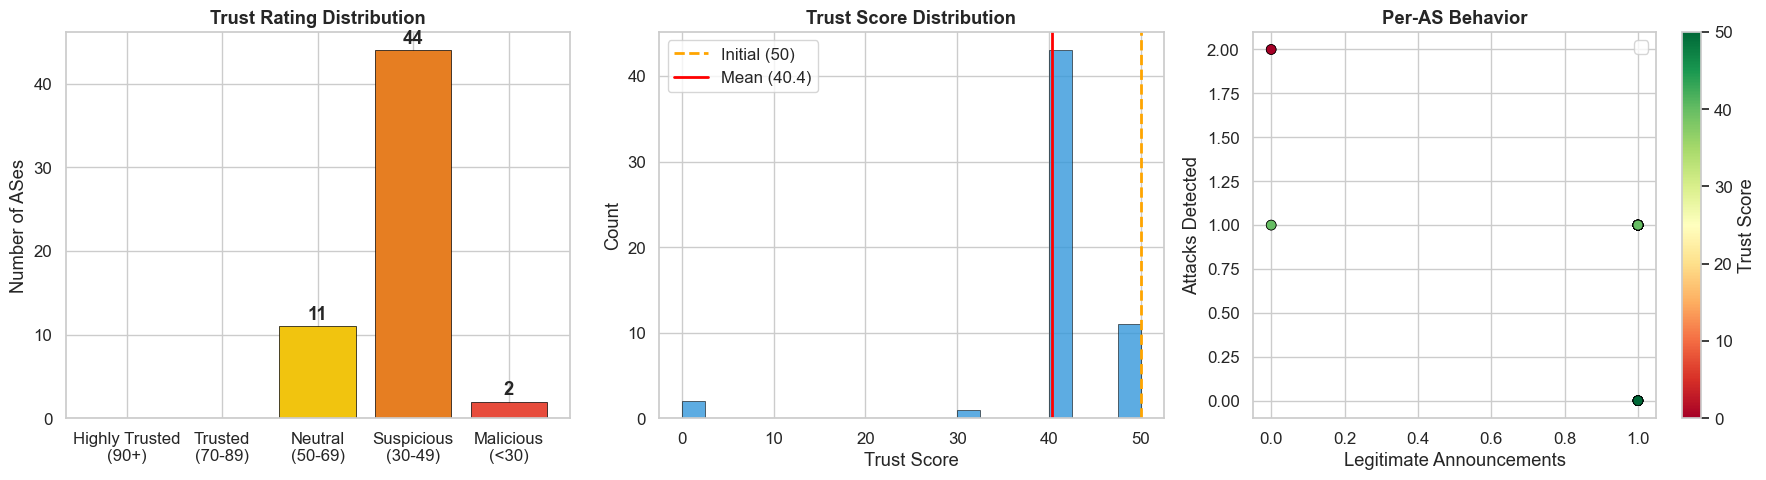

In [10]:
ratings_summary = nonrpki_ratings["summary"]
all_ratings = nonrpki_ratings["ratings"]

# Summary table
rating_df = pd.DataFrame([
    ("Total Rated ASes", ratings_summary.get("total_ases", 0)),
    ("Average Score", f"{ratings_summary.get('average_score', 0):.2f}"),
    ("Min Score", ratings_summary.get("min_score", "N/A")),
    ("Max Score", ratings_summary.get("max_score", "N/A")),
    ("Total Attacks Detected", ratings_summary.get("total_attacks", 0)),
], columns=["Metric", "Value"])
display(rating_df.style.hide(axis="index").set_properties(**{'text-align': 'left'}))

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Rating level distribution
by_level = ratings_summary.get("by_level", {})
level_order = ["highly_trusted", "trusted", "neutral", "suspicious", "malicious"]
level_labels = ["Highly Trusted\n(90+)", "Trusted\n(70-89)", "Neutral\n(50-69)",
                "Suspicious\n(30-49)", "Malicious\n(<30)"]
level_colors = ["#27ae60", "#2ecc71", "#f1c40f", "#e67e22", "#e74c3c"]
counts = [by_level.get(l, 0) for l in level_order]

bars = axes[0].bar(level_labels, counts, color=level_colors, edgecolor="black", linewidth=0.5)
for bar, val in zip(bars, counts):
    if val > 0:
        axes[0].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.3,
                    str(val), ha='center', va='bottom', fontweight='bold')
axes[0].set_title("Trust Rating Distribution", fontweight="bold")
axes[0].set_ylabel("Number of ASes")

# 2. Trust score histogram
scores = [info["trust_score"] for info in all_ratings.values()]
if scores:
    axes[1].hist(scores, bins=20, color="#3498db", edgecolor="black", linewidth=0.5, alpha=0.8)
    axes[1].axvline(x=50, color='orange', linestyle='--', linewidth=2, label='Initial (50)')
    axes[1].axvline(x=np.mean(scores), color='red', linestyle='-', linewidth=2,
                    label=f'Mean ({np.mean(scores):.1f})')
    axes[1].set_title("Trust Score Distribution", fontweight="bold")
    axes[1].set_xlabel("Trust Score")
    axes[1].set_ylabel("Count")
    axes[1].legend()

# 3. Attacks vs legitimate per AS
attack_counts = []
legit_counts = []
as_labels = []
for asn_str, info in sorted(all_ratings.items(), key=lambda x: x[1]["trust_score"]):
    attack_counts.append(info.get("attacks_detected", 0))
    legit_counts.append(info.get("legitimate_announcements", 0))
    as_labels.append(f"AS{asn_str}")

if len(as_labels) <= 30:
    x = range(len(as_labels))
    axes[2].bar(x, attack_counts, color="#e74c3c", label="Attacks", alpha=0.8)
    axes[2].bar(x, legit_counts, bottom=attack_counts, color="#2ecc71", label="Legitimate", alpha=0.8)
    axes[2].set_xticks(x)
    axes[2].set_xticklabels(as_labels, rotation=90, fontsize=7)
else:
    # Too many ASes, show summary
    axes[2].scatter(legit_counts, attack_counts, c=[info["trust_score"] for info in
                    sorted(all_ratings.values(), key=lambda x: x["trust_score"])],
                   cmap="RdYlGn", s=50, edgecolors="black", linewidth=0.5)
    axes[2].set_xlabel("Legitimate Announcements")
    axes[2].set_ylabel("Attacks Detected")
    plt.colorbar(axes[2].collections[0], ax=axes[2], label="Trust Score")
axes[2].set_title("Per-AS Behavior", fontweight="bold")
axes[2].legend()

plt.tight_layout()
plt.savefig(RESULTS_DIR / "fig_trust_ratings.png", dpi=150, bbox_inches="tight")
plt.show()

## 7. P2P Network & Deduplication

Delivery rate: 100.0000%
Messages/second: 15,688


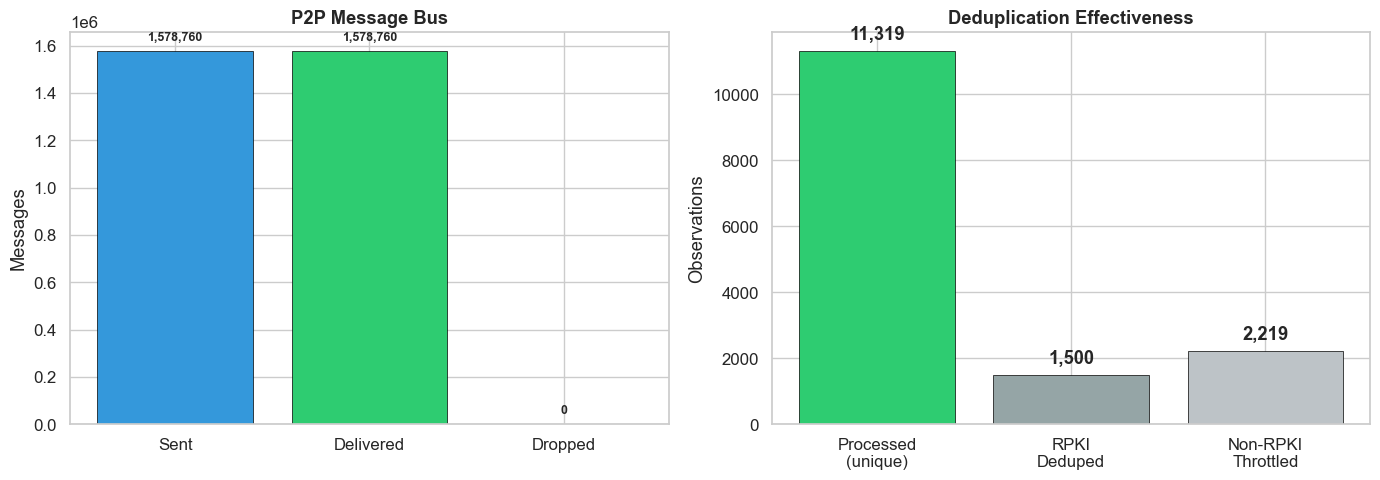

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Message bus stats
sent = bus_stats.get("sent", 0)
delivered = bus_stats.get("delivered", 0)
dropped = bus_stats.get("dropped", 0)

labels = ["Sent", "Delivered", "Dropped"]
values = [sent, delivered, dropped]
colors = ["#3498db", "#2ecc71", "#e74c3c"]
bars = axes[0].bar(labels, values, color=colors, edgecolor="black", linewidth=0.5)
for bar, val in zip(bars, values):
    axes[0].text(bar.get_x() + bar.get_width()/2., bar.get_height() + max(values)*0.02,
                f'{val:,}', ha='center', va='bottom', fontweight='bold', fontsize=9)
axes[0].set_title("P2P Message Bus", fontweight="bold")
axes[0].set_ylabel("Messages")

delivery_rate = delivered / max(sent, 1) * 100
print(f"Delivery rate: {delivery_rate:.4f}%")
print(f"Messages/second: {sent / summary['elapsed_seconds']:,.0f}")

# 2. Deduplication
rpki_dedup = dedup_stats.get("rpki_deduped", 0)
nonrpki_throttled = dedup_stats.get("nonrpki_throttled", 0)
total_processed = summary["node_summary"].get("total_observations_processed", 0)
total_obs = summary["dataset"].get("total_observations", 0)

dedup_labels = ["Processed\n(unique)", "RPKI\nDeduped", "Non-RPKI\nThrottled"]
dedup_vals = [total_processed - rpki_dedup - nonrpki_throttled, rpki_dedup, nonrpki_throttled]
dedup_colors = ["#2ecc71", "#95a5a6", "#bdc3c7"]
bars = axes[1].bar(dedup_labels, dedup_vals, color=dedup_colors, edgecolor="black", linewidth=0.5)
for bar, val in zip(bars, dedup_vals):
    axes[1].text(bar.get_x() + bar.get_width()/2., bar.get_height() + max(dedup_vals)*0.02,
                f'{val:,}', ha='center', va='bottom', fontweight='bold')
axes[1].set_title("Deduplication Effectiveness", fontweight="bold")
axes[1].set_ylabel("Observations")

plt.tight_layout()
plt.savefig(RESULTS_DIR / "fig_network_dedup.png", dpi=150, bbox_inches="tight")
plt.show()

## 8. Cryptographic Signing

In [12]:
crypto_df = pd.DataFrame([
    ("Key Algorithm", crypto_summary.get("key_algorithm", "N/A")),
    ("Signature Scheme", crypto_summary.get("signature_scheme", "N/A")),
    ("Total Key Pairs", crypto_summary.get("total_key_pairs", 0)),
    ("Public Key Registry Size", crypto_summary.get("public_key_registry_size", 0)),
], columns=["Metric", "Value"])

display(crypto_df.style.hide(axis="index").set_properties(**{'text-align': 'left'}))

# Check if keys were saved to disk
from pathlib import Path
keys_dir = Path(RESULTS_DIR).parent.parent.parent / "blockchain_data" / "nodes"
if keys_dir.exists():
    key_count = sum(1 for d in keys_dir.iterdir() if (d / "keys" / "private_key.pem").exists())
    print(f"\nPer-node private keys on disk: {key_count}")
    registry_path = keys_dir.parent / "public_key_registry.json"
    if registry_path.exists():
        with open(registry_path) as f:
            reg = json.load(f)
        print(f"Public key registry on disk: {len(reg)} entries")
else:
    print("\nKeys saved during simulation runtime (blockchain_data/nodes/)")

Metric,Value
Key Algorithm,RSA-2048
Signature Scheme,RSA-PSS with SHA-256
Total Key Pairs,101
Public Key Registry Size,101



Per-node private keys on disk: 101


Public key registry on disk: 101 entries


## 9. Attack Verdict Analysis

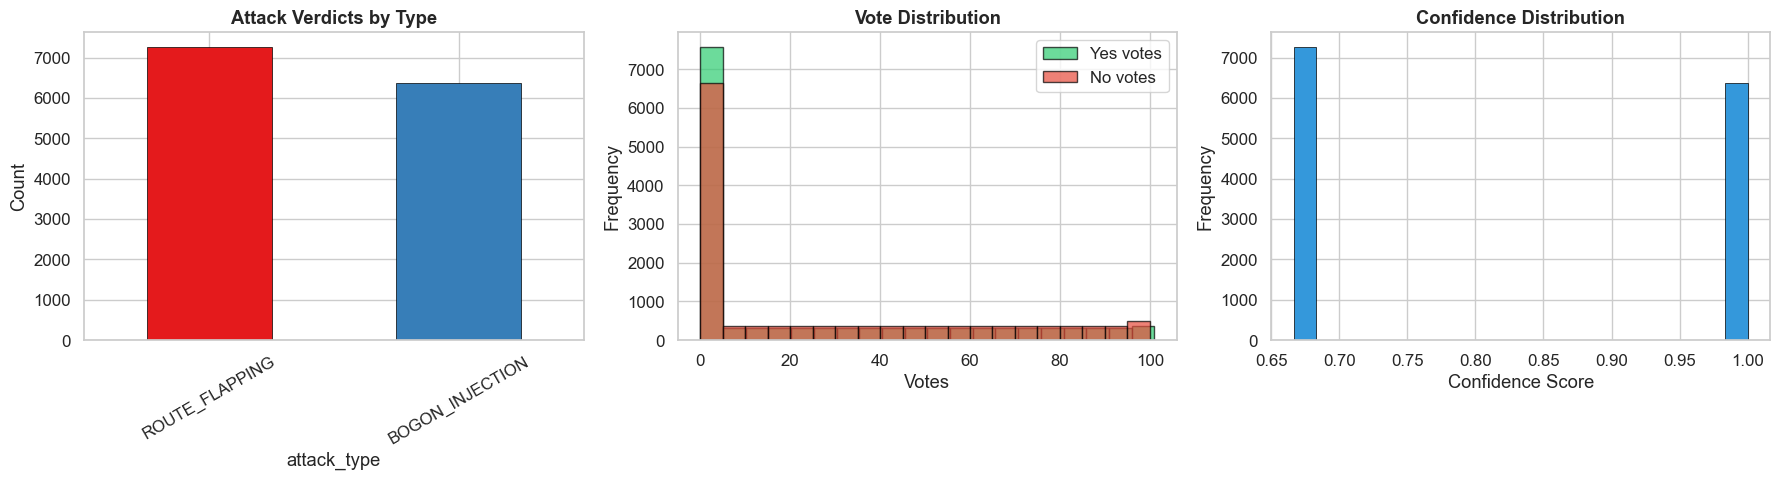

Total attack proposals: 13,635

Breakdown:
  ROUTE_FLAPPING: 7,272
  BOGON_INJECTION: 6,363


In [13]:
if attack_verdicts:
    av_df = pd.DataFrame(attack_verdicts)

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # 1. Attack type distribution
    if "attack_type" in av_df.columns:
        type_counts = av_df["attack_type"].value_counts()
        type_counts.plot.bar(ax=axes[0], color=sns.color_palette("Set1", len(type_counts)),
                             edgecolor="black", linewidth=0.5)
        axes[0].set_title("Attack Verdicts by Type", fontweight="bold")
        axes[0].set_ylabel("Count")
        axes[0].tick_params(axis='x', rotation=30)

    # 2. Vote distribution
    if "yes_votes" in av_df.columns and "no_votes" in av_df.columns:
        axes[1].hist(av_df["yes_votes"], bins=20, alpha=0.7, color="#2ecc71", label="Yes votes", edgecolor="black")
        axes[1].hist(av_df["no_votes"], bins=20, alpha=0.7, color="#e74c3c", label="No votes", edgecolor="black")
        axes[1].set_title("Vote Distribution", fontweight="bold")
        axes[1].set_xlabel("Votes")
        axes[1].set_ylabel("Frequency")
        axes[1].legend()

    # 3. Confidence distribution
    if "confidence" in av_df.columns:
        conf = av_df["confidence"].dropna()
        if len(conf) > 0:
            axes[2].hist(conf, bins=20, color="#3498db", edgecolor="black", linewidth=0.5)
            axes[2].set_title("Confidence Distribution", fontweight="bold")
            axes[2].set_xlabel("Confidence Score")
            axes[2].set_ylabel("Frequency")

    plt.tight_layout()
    plt.savefig(RESULTS_DIR / "fig_attack_verdicts.png", dpi=150, bbox_inches="tight")
    plt.show()

    print(f"Total attack proposals: {len(av_df):,}")
    if "attack_type" in av_df.columns:
        print(f"\nBreakdown:")
        for atype, count in av_df["attack_type"].value_counts().items():
            print(f"  {atype}: {count:,}")
else:
    print("No attack verdicts recorded.")

## 10. Real-Time Feasibility Analysis

The simulation processes a 3-minute window of BGP observations. Can this system operate
in **real-time** — processing observations as fast as they arrive?

REAL-TIME FEASIBILITY REPORT



Metric,Value
Simulation duration,100.6s
Simulated time window,180s (3 min)
Total observations,"15,038"
Observation arrival rate,83.5 obs/sec
,
Processing throughput,149.4 obs/sec
Block production rate,17.6 blocks/sec
Transaction creation rate,55.4 tx/sec
Consensus commit rate,18.1 commits/sec
P2P message rate,"15,688 msgs/sec"



VERDICT: YES - System processes faster than real-time


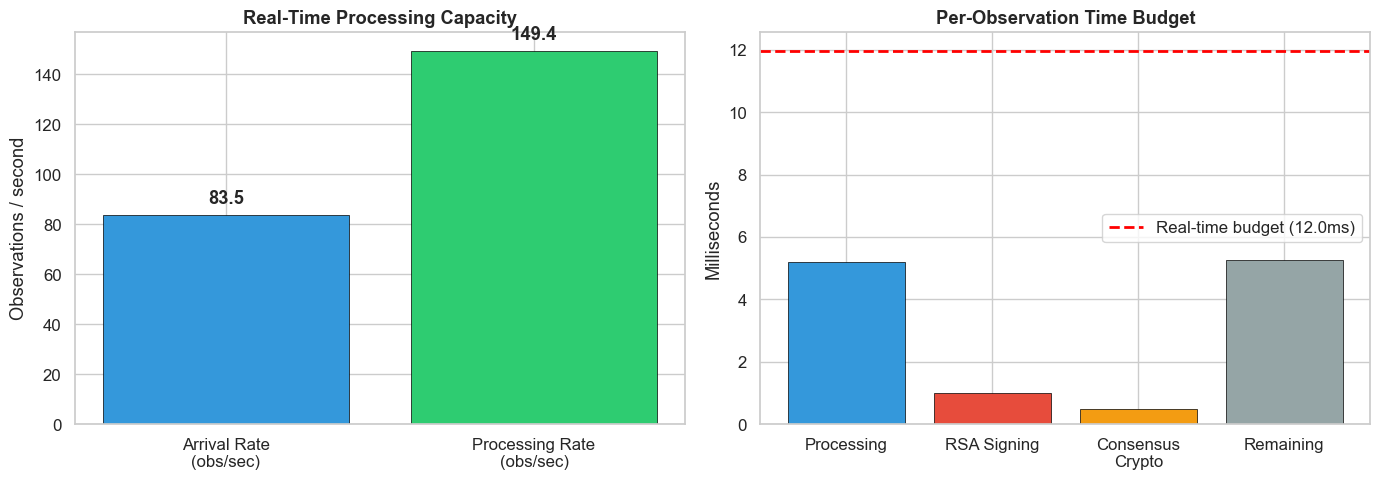

In [14]:
elapsed = summary["elapsed_seconds"]
total_obs = summary["dataset"]["total_observations"]
total_nodes = summary["dataset"]["total_ases"]
rpki_count = summary["dataset"]["rpki_count"]
blocks = blockchain_stats["blockchain_info"].get("total_blocks", 0)
msgs_sent = bus_stats.get("sent", 0)
committed = consensus_log.get("total_committed", 0)
created = consensus_log.get("total_transactions_created", 0)

# Throughput calculations
obs_per_sec = total_obs / elapsed
blocks_per_sec = blocks / elapsed
msgs_per_sec = msgs_sent / elapsed
tx_per_sec = created / elapsed
commit_per_sec = committed / elapsed

# Real-time requirement: process observations at arrival rate
# In the dataset, observations span a 3-minute simulated window
# But in real BGP, a typical AS sees ~10-100 updates/sec
# Our simulation: total_obs / 180s (3-minute simulation window)
arrival_rate = total_obs / 180  # observations per second in simulated time

# Processing budget per observation
budget_per_obs_ms = (elapsed / total_obs) * 1000

# Signature overhead estimate (RSA-2048: ~1ms sign, ~0.1ms verify)
sign_overhead_ms = 1.0
verify_overhead_per_vote_ms = 0.1
consensus_threshold = run_config.get("consensus_threshold", 5)
total_crypto_overhead_ms = sign_overhead_ms + consensus_threshold * verify_overhead_per_vote_ms

print("=" * 60)
print("REAL-TIME FEASIBILITY REPORT")
print("=" * 60)
print()

feasibility = pd.DataFrame([
    ("Simulation duration", f"{elapsed:.1f}s"),
    ("Simulated time window", "180s (3 min)"),
    ("Total observations", f"{total_obs:,}"),
    ("Observation arrival rate", f"{arrival_rate:.1f} obs/sec"),
    ("", ""),
    ("Processing throughput", f"{obs_per_sec:.1f} obs/sec"),
    ("Block production rate", f"{blocks_per_sec:.1f} blocks/sec"),
    ("Transaction creation rate", f"{tx_per_sec:.1f} tx/sec"),
    ("Consensus commit rate", f"{commit_per_sec:.1f} commits/sec"),
    ("P2P message rate", f"{msgs_per_sec:,.0f} msgs/sec"),
    ("", ""),
    ("Time budget per observation", f"{budget_per_obs_ms:.2f} ms"),
    ("RSA signing overhead", f"{sign_overhead_ms:.1f} ms"),
    ("Consensus crypto overhead", f"{total_crypto_overhead_ms:.1f} ms"),
    ("", ""),
    ("Real-time ratio", f"{elapsed / 180:.2f}x"),
], columns=["Metric", "Value"])
display(feasibility.style.hide(axis="index").set_properties(**{'text-align': 'left'}))

realtime_ratio = elapsed / 180
if realtime_ratio <= 1.0:
    verdict = "YES - System processes faster than real-time"
    color = "#2ecc71"
elif realtime_ratio <= 2.0:
    verdict = "MARGINAL - System is 1-2x slower than real-time"
    color = "#f39c12"
else:
    verdict = f"NO - System is {realtime_ratio:.1f}x slower than real-time"
    color = "#e74c3c"

print(f"\nVERDICT: {verdict}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Real-time ratio gauge
categories = ["Arrival Rate\n(obs/sec)", "Processing Rate\n(obs/sec)"]
rates = [arrival_rate, obs_per_sec]
colors = ["#3498db", "#2ecc71" if obs_per_sec >= arrival_rate else "#e74c3c"]
bars = axes[0].bar(categories, rates, color=colors, edgecolor="black", linewidth=0.5)
for bar, val in zip(bars, rates):
    axes[0].text(bar.get_x() + bar.get_width()/2., bar.get_height() + max(rates)*0.02,
                f'{val:.1f}', ha='center', va='bottom', fontweight='bold')
axes[0].set_title("Real-Time Processing Capacity", fontweight="bold")
axes[0].set_ylabel("Observations / second")

# 2. Time budget breakdown
budget_items = ["Processing", "RSA Signing", "Consensus\nCrypto", "Remaining"]
budget_vals = [
    budget_per_obs_ms - total_crypto_overhead_ms,
    sign_overhead_ms,
    total_crypto_overhead_ms - sign_overhead_ms,
    max(0, (1000 / arrival_rate) - budget_per_obs_ms) if arrival_rate > 0 else 0,
]
budget_colors = ["#3498db", "#e74c3c", "#f39c12", "#95a5a6"]
axes[1].bar(budget_items, budget_vals, color=budget_colors, edgecolor="black", linewidth=0.5)
axes[1].axhline(y=1000/arrival_rate if arrival_rate > 0 else 0, color="red", linestyle="--",
                linewidth=2, label=f"Real-time budget ({1000/arrival_rate:.1f}ms)")
axes[1].set_title("Per-Observation Time Budget", fontweight="bold")
axes[1].set_ylabel("Milliseconds")
axes[1].legend()

plt.tight_layout()
plt.savefig(RESULTS_DIR / "fig_realtime_feasibility.png", dpi=150, bbox_inches="tight")
plt.show()

## 11. Summary Dashboard

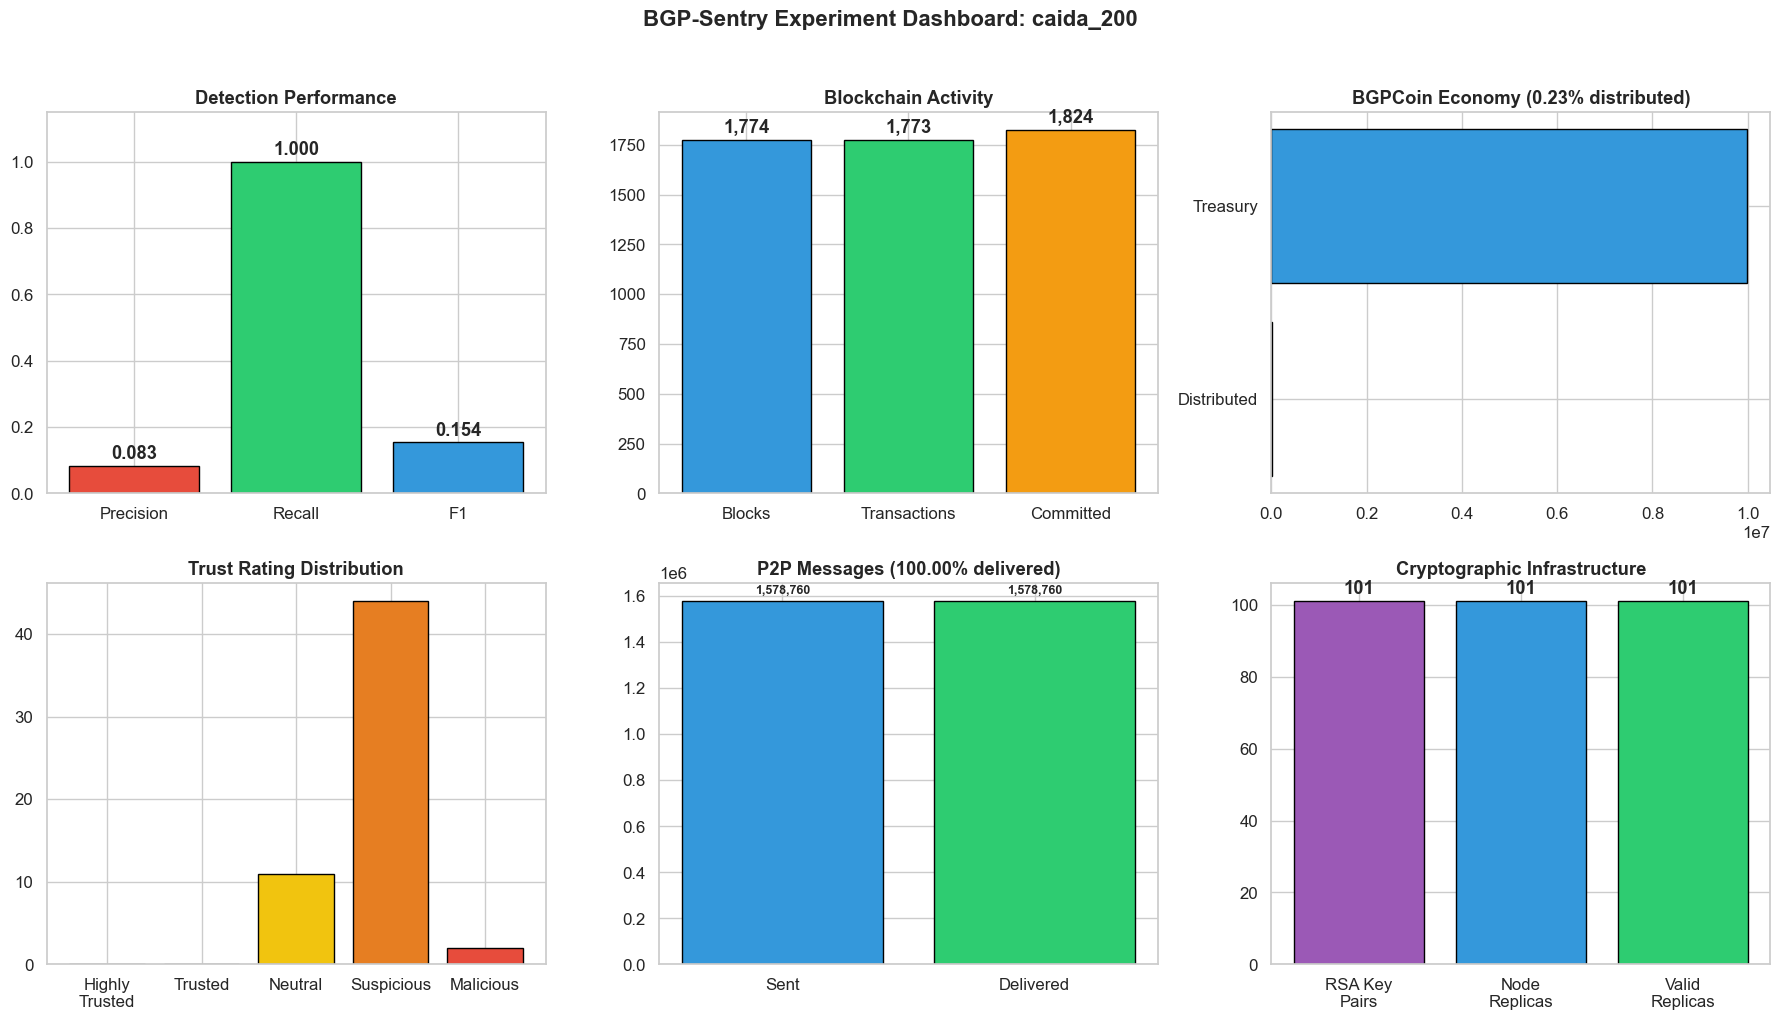

In [15]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Detection Performance gauge
ax = axes[0, 0]
metrics_names = ["Precision", "Recall", "F1"]
metrics_vals = [performance["precision"], performance["recall"], performance["f1_score"]]
colors = ["#e74c3c", "#2ecc71", "#3498db"]
bars = ax.bar(metrics_names, metrics_vals, color=colors, edgecolor="black")
for bar, val in zip(bars, metrics_vals):
    ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.02,
            f'{val:.3f}', ha='center', fontweight='bold')
ax.set_ylim(0, 1.15)
ax.set_title("Detection Performance", fontweight="bold")

# 2. Blockchain Health
ax = axes[0, 1]
bc_metrics = ["Blocks", "Transactions", "Committed"]
bc_vals = [
    blockchain_stats["blockchain_info"].get("total_blocks", 0),
    blockchain_stats["blockchain_info"].get("total_transactions", 0),
    consensus_log.get("total_committed", 0),
]
ax.bar(bc_metrics, bc_vals, color=["#3498db", "#2ecc71", "#f39c12"], edgecolor="black")
for i, (m, v) in enumerate(zip(bc_metrics, bc_vals)):
    ax.text(i, v + max(bc_vals)*0.02, f'{v:,}', ha='center', fontweight='bold')
ax.set_title("Blockchain Activity", fontweight="bold")

# 3. Token Economy
ax = axes[0, 2]
supply = bgpcoin_economy.get("total_supply", 10_000_000)
distributed = bgpcoin_economy.get("total_distributed", 0)
pct = distributed / supply * 100
ax.barh(["Distributed", "Treasury"], [distributed, supply - distributed],
        color=["#2ecc71", "#3498db"], edgecolor="black")
ax.set_title(f"BGPCoin Economy ({pct:.2f}% distributed)", fontweight="bold")

# 4. Trust Rating Distribution
ax = axes[1, 0]
by_level = nonrpki_ratings["summary"].get("by_level", {})
level_names = ["Highly\nTrusted", "Trusted", "Neutral", "Suspicious", "Malicious"]
level_keys = ["highly_trusted", "trusted", "neutral", "suspicious", "malicious"]
level_vals = [by_level.get(k, 0) for k in level_keys]
level_colors = ["#27ae60", "#2ecc71", "#f1c40f", "#e67e22", "#e74c3c"]
ax.bar(level_names, level_vals, color=level_colors, edgecolor="black")
ax.set_title("Trust Rating Distribution", fontweight="bold")

# 5. P2P Network
ax = axes[1, 1]
msg_labels = ["Sent", "Delivered"]
msg_vals = [bus_stats.get("sent", 0), bus_stats.get("delivered", 0)]
ax.bar(msg_labels, msg_vals, color=["#3498db", "#2ecc71"], edgecolor="black")
for i, v in enumerate(msg_vals):
    ax.text(i, v + max(msg_vals)*0.02, f'{v:,}', ha='center', fontweight='bold', fontsize=9)
delivery_pct = msg_vals[1] / max(msg_vals[0], 1) * 100
ax.set_title(f"P2P Messages ({delivery_pct:.2f}% delivered)", fontweight="bold")

# 6. Crypto & Replicas
ax = axes[1, 2]
replica_info = blockchain_stats.get("node_replicas", {})
total_replicas = replica_info.get("total_nodes", 0)
valid_replicas = replica_info.get("valid_count", 0)
key_pairs = crypto_summary.get("total_key_pairs", 0)

cr_labels = ["RSA Key\nPairs", "Node\nReplicas", "Valid\nReplicas"]
cr_vals = [key_pairs, total_replicas, valid_replicas]
cr_colors = ["#9b59b6", "#3498db", "#2ecc71"]
ax.bar(cr_labels, cr_vals, color=cr_colors, edgecolor="black")
for i, v in enumerate(cr_vals):
    ax.text(i, v + max(cr_vals)*0.02, str(v), ha='center', fontweight='bold')
ax.set_title("Cryptographic Infrastructure", fontweight="bold")

plt.suptitle(f"BGP-Sentry Experiment Dashboard: {summary['dataset']['dataset_name']}",
             fontsize=16, fontweight="bold", y=1.02)
plt.tight_layout()
plt.savefig(RESULTS_DIR / "fig_dashboard.png", dpi=150, bbox_inches="tight")
plt.show()

## 12. Complete Metrics Table

In [16]:
all_metrics = pd.DataFrame([
    ("Dataset", "Name", summary["dataset"].get("dataset_name")),
    ("Dataset", "Total ASes", summary["dataset"].get("total_ases")),
    ("Dataset", "RPKI Validators", summary["dataset"].get("rpki_count")),
    ("Dataset", "Non-RPKI Observers", summary["dataset"].get("non_rpki_count")),
    ("Dataset", "Total Observations", f"{summary['dataset'].get('total_observations', 0):,}"),
    ("Dataset", "Attack Observations", f"{summary['dataset'].get('attack_observations', 0):,}"),
    ("Detection", "Precision", f"{performance['precision']:.4f}"),
    ("Detection", "Recall", f"{performance['recall']:.4f}"),
    ("Detection", "F1 Score", f"{performance['f1_score']:.4f}"),
    ("Detection", "True Positives", performance["true_positives"]),
    ("Detection", "False Positives", performance["false_positives"]),
    ("Detection", "False Negatives", performance["false_negatives"]),
    ("Blockchain", "Total Blocks", f"{blockchain_stats['blockchain_info'].get('total_blocks', 0):,}"),
    ("Blockchain", "Integrity Valid", "Yes" if blockchain_stats["integrity"].get("valid") else "No"),
    ("Blockchain", "Node Replicas", blockchain_stats.get("node_replicas", {}).get("total_nodes", 0)),
    ("Blockchain", "All Replicas Valid", "Yes" if blockchain_stats.get("node_replicas", {}).get("all_valid") else "No"),
    ("Consensus", "Transactions Created", f"{consensus_log.get('total_transactions_created', 0):,}"),
    ("Consensus", "Committed", f"{consensus_log.get('total_committed', 0):,}"),
    ("Consensus", "Commit Rate", f"{consensus_log.get('total_committed', 0)/max(consensus_log.get('total_transactions_created', 1),1):.1%}"),
    ("Economy", "BGPCOIN Distributed", f"{bgpcoin_economy.get('total_distributed', 0):,.0f}"),
    ("Economy", "Circulating Supply", f"{bgpcoin_economy.get('circulating_supply', 0):,.0f}"),
    ("Trust", "Rated ASes", nonrpki_ratings["summary"].get("total_ases", 0)),
    ("Trust", "Average Score", f"{nonrpki_ratings['summary'].get('average_score', 0):.2f}"),
    ("Network", "P2P Messages", f"{bus_stats.get('sent', 0):,}"),
    ("Network", "Delivery Rate", f"{bus_stats.get('delivered', 0)/max(bus_stats.get('sent', 1),1):.4%}"),
    ("Crypto", "Key Pairs", crypto_summary.get("total_key_pairs", 0)),
    ("Crypto", "Algorithm", crypto_summary.get("key_algorithm", "N/A")),
    ("Dedup", "RPKI Deduped", f"{dedup_stats.get('rpki_deduped', 0):,}"),
    ("Dedup", "Non-RPKI Throttled", f"{dedup_stats.get('nonrpki_throttled', 0):,}"),
    ("Performance", "Duration", f"{summary['elapsed_seconds']:.1f}s"),
    ("Performance", "Real-time Ratio", f"{summary['elapsed_seconds']/180:.2f}x"),
], columns=["Category", "Metric", "Value"])

display(all_metrics.style.hide(axis="index").set_properties(**{'text-align': 'left'}))

Category,Metric,Value
Dataset,Name,caida_200
Dataset,Total ASes,200
Dataset,RPKI Validators,101
Dataset,Non-RPKI Observers,99
Dataset,Total Observations,"15,038"
Dataset,Attack Observations,476
Detection,Precision,0.0833
Detection,Recall,1.0000
Detection,F1 Score,0.1538
Detection,True Positives,4
